# ActivityRecognition




##Problem Statement


This project is to build a model that predicts the activities such as 0 or 1.

The Dataset consists of 2000 observations and each observation has timesteps between 500(minimum) to 600(maximum) with 10 different features

In [43]:
# Importing libraries
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from keras.layers.core import Dense, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, SparseCategoricalCrossentropy,BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print('The the libraries has been imported sucessfully')

The the libraries has been imported sucessfully


In [3]:
#Setting up working directory
%cd /content/drive/MyDrive/task
current_dir=!pwd
print('The working director has been change to',current_dir)

/content/drive/MyDrive/task
The working director has been change to ['/content/drive/MyDrive/task']


In [4]:
#Getting the directories path
data_pickle= '/content/drive/MyDrive/task/data.pickle'
data_csv= '/content/drive/MyDrive/task/data.csv'

In [5]:
#Reading the datasets
df_pickle=pd.read_pickle(data_pickle)                     
df_csv=pd.read_csv(data_csv)                             

The number of points belonging to Oth class----> 0.8875
The number of points belonging to 1th class----->0.1125


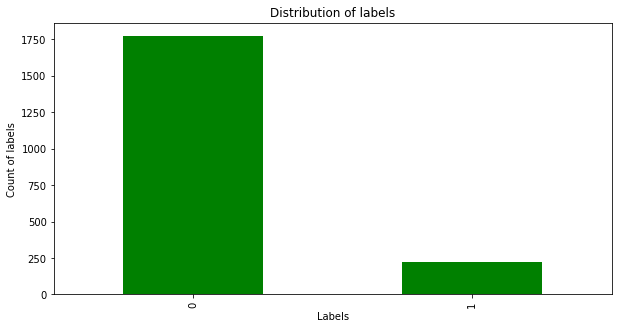

In [32]:
value=df_csv['selected_event'].value_counts()
print('The number of points belonging to Oth class----> {}'.format(value[0]/len(df_csv)))
print('The number of points belonging to 1th class----->{}'.format(value[1]/len(df_csv)))
value_df=pd.DataFrame(value)
fig = plt.figure(figsize = (10, 5))
value_df['selected_event'].plot.bar(color='green')
plt.xlabel("Labels")
plt.ylabel("Count of labels")
plt.title("Distribution of labels")
plt.show()

From the above cell, it was found that the dataset is completly imbalanced by with 88.75% of points belonging to class0, and 11.25% of points belonging to class1. 



In [ ]:
#Check of max timestep avaliable in the dataset
print('The max timestep avaliable in the dataset is:', max(df_csv['X_length']))

The max timestep avaliable in the dataset is: 600


In [9]:
#This step is to pad each datapoint to maximum timestemp
pickle_lst=[]
for i in range(2000):
  an_array = df_pickle[i]        #Taking each datapoint and padding it to maximum timesteps
  shape = np.shape(an_array)
  padded_array = np.zeros((600, 10))
  padded_array[:shape[0],:] = an_array
  pickle_lst.append(padded_array)

print('Sucesfully padded to max timestep for each datapoint for uniformity')

Sucesfully padded to max timestep for each datapoint for uniformity


In [ ]:
#with open('padded_list','wb') as f:
  #pickle.dump(lst,f)
print('The pickle file is created with 600 timesteps each datapoint')

The pickle file is created with 600 timesteps each datapoint


In [7]:
features=['feature_'+str(i+1) for i in range(10)]
print('The features are labled as follows', features)

The features are labled as follows ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10']


In [10]:
# Concatinating the complete dataset according to their features
total_df=pd.DataFrame(columns=features)
for elm in range(2000):
  total=pd.DataFrame(pickle_lst[elm],columns=features)
  total_df= pd.concat([total_df,total])
print('The dataset is sucessfully prepared and read to use')
print('The dataset contains {} rows and {} columns'.format(total_df.shape[0],total_df.shape[1]))

The dataset is sucessfully prepared and read to use
The dataset contains 1200000 rows and 10 columns


In [ ]:
#Dumping the dataframe into a pickle for future use
#with open('total_data','wb') as f:
  #pickle.dump(total_df,f)
print('The pickle is sucessfully created and store at ', str(current_dir) + '/total_data')

The pickle is sucessfully created and store at  ['/content/drive/MyDrive/task']/total_data


In [11]:
#Reading pickle file after the storage to check with conformance
total_data=pd.read_pickle('/content/drive/MyDrive/task/total_data')
print('The shape of total_data is', total_data.shape)
print('Checking top 5 rows of total_data')
print(total_data.head())
#Resetting index and droping it
total_reset_index=total_data.reset_index(drop=True)               
print(total_reset_index.shape)

The shape of total_data is (1200000, 10)
Checking top 5 rows of total_data
   feature_1  feature_2  feature_3  ...  feature_8  feature_9  feature_10
0   0.921342   0.157051   0.197420  ...       -1.0        1.0    0.996094
1   0.939820   0.033015   0.028768  ...       -1.0        1.0    0.996094
2   0.975476   0.032562   0.045972  ...       -1.0        1.0    0.996094
3   0.939574   0.011160   0.016909  ...       -1.0        1.0    0.996094
4   0.920411   0.014498   0.020829  ...       -1.0        1.0    0.996094

[5 rows x 10 columns]
(1200000, 10)


In [12]:
#checking any null values present in dataset
is_null=total_reset_index.isnull().sum()
print('The number of NaN values present in the each feature are as follows')
print(is_null)

The number of NaN values present in the each feature are as follows
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
dtype: int64


In [ ]:
#Total describtion of features
print('The below table shows the stats of each column \n')
print('--'*50)
total_reset_index.describe()

The below table shows the stats of each column 

----------------------------------------------------------------------------------------------------


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
count,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06
mean,8.784803e-01,4.179583e-02,4.150485e-02,4.364434e-02,4.198012e-02,4.161155e-02,6.292847e-02,-4.957707e-01,6.277183e-01,3.967422e-01
std,2.008115e-01,9.011182e-02,9.304444e-02,1.030730e-01,9.705146e-02,9.653986e-02,1.287700e-01,6.808996e-01,4.834131e-01,4.835997e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00
25%,8.909481e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.582100e-03,-1.000000e+00,0.000000e+00,0.000000e+00
50%,9.391456e-01,2.467649e-03,1.310436e-03,0.000000e+00,0.000000e+00,0.000000e+00,6.490912e-03,-1.000000e+00,1.000000e+00,0.000000e+00
75%,9.645201e-01,3.642812e-02,3.252322e-02,2.909413e-02,2.922171e-02,2.833681e-02,3.137831e-02,3.097105e-05,1.000000e+00,9.960938e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.049713e+00,1.000000e+00,1.005076e+00,2.818892e+00,1.000000e+00,1.000000e+00,9.960938e-01


From the above stats table it is evident that almost every feature value is ranging from 0 to 1 expect for feature 8 and feature 7 
*   Feature 7 max value is 2.88 and min is 0
*   Feature 8 max value is 1 and min is -1

Therefore it is very much necaessary to normalize the columns thereby output won't be effected



## Exploratory Data Analysis of features

In this section data analysis is performed on each feature to know the distribution of each feature and further the dataset is divide according to the class labels and further analysed the distribution according their classes

###The plot for complete dataset (Includes both the class labels)

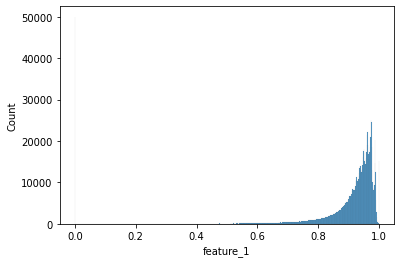

In [ ]:
#Plotting complete dataset to see which features are more important for analysis
sns.histplot(total_reset_index['feature_1'])

From the above graph majority values lies between 0.8 and 1 for both the classes (0 and 1)

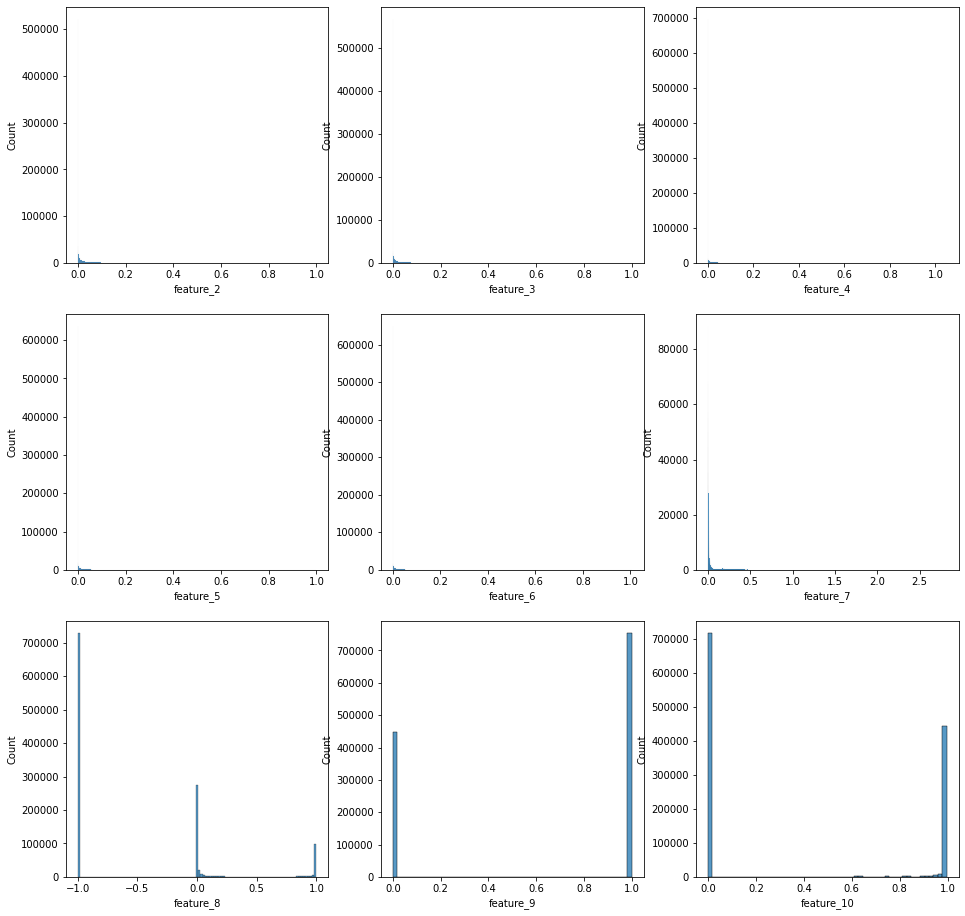

In [ ]:
fig, axes = plt.subplots(3, 3,figsize=(16, 16))
sns.histplot(total_reset_index['feature_2'],ax = axes[0][0])
sns.histplot(total_reset_index['feature_3'],ax = axes[0][1])
sns.histplot(total_reset_index['feature_4'],ax = axes[0][2])
sns.histplot(total_reset_index['feature_5'],ax = axes[1][0])
sns.histplot(total_reset_index['feature_6'],ax = axes[1][1])
sns.histplot(total_reset_index['feature_7'],ax = axes[1][2])
sns.histplot(total_reset_index['feature_8'],ax = axes[2][0])
sns.histplot(total_reset_index['feature_9'],ax = axes[2][1])
sns.histplot(total_reset_index['feature_10'],ax = axes[2][2])

*   From the above graphs it is found that majority of values of feature2, feature3, feature4, feature5, feature6, feature7 are around 0 for both the classes

*   Unlike other features, feature 8  has most of the denstity focused at -1.0 
*   feature 9, feature 10 has majority values foucsing at 1.0 

**The conclusion is that feature 1, feature 8, feature 9, feature 10 plays important role in developing a model. **







(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

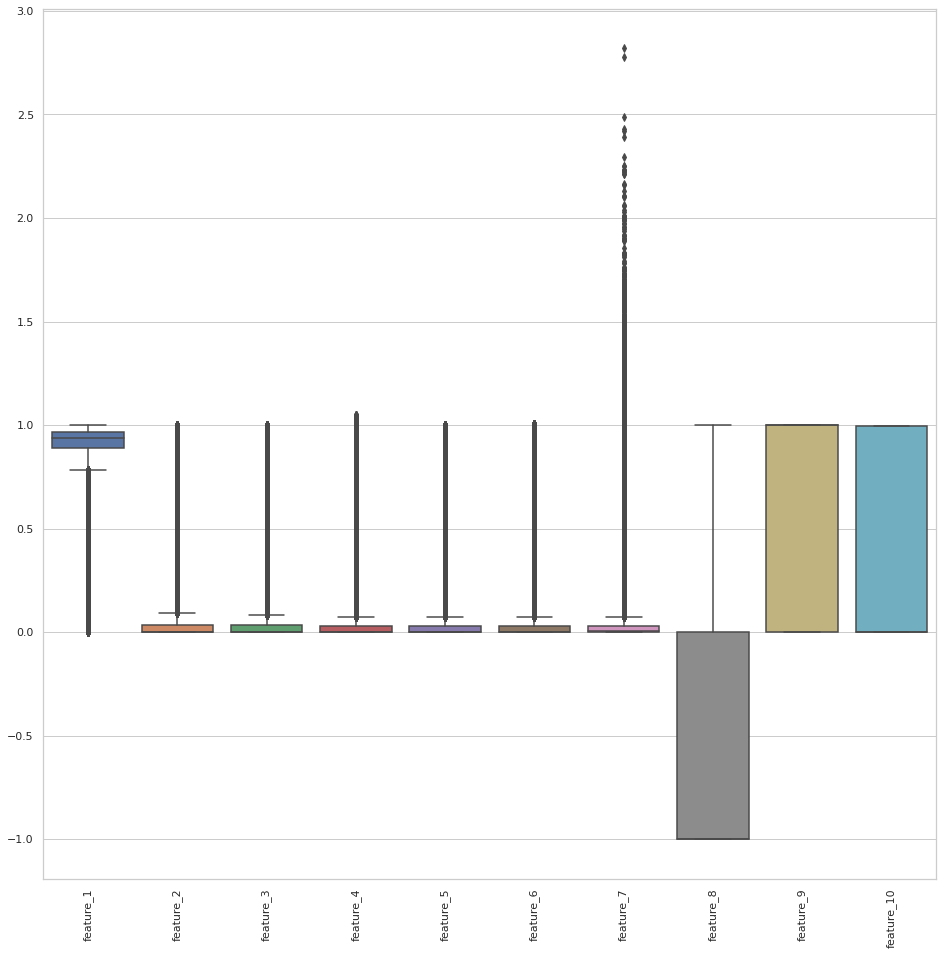

In [ ]:
#ploting box plot
fig = plt.figure(figsize = (16, 16))
sns.boxplot(data=total_reset_index)
plt.xticks(rotation = 'vertical')

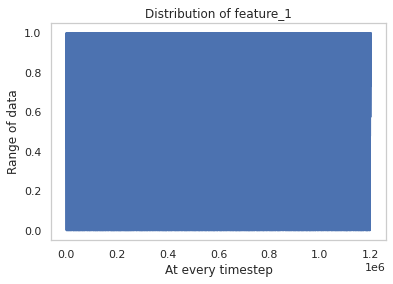

In [ ]:
total_reset_index['feature_1'].plot()
plt.xlabel("At every timestep")
plt.ylabel("Range of data")
plt.title("Line plot of feature_1")
plt.grid(b=None)
plt.show()

Text(0, 0.5, 'Value at each time step')

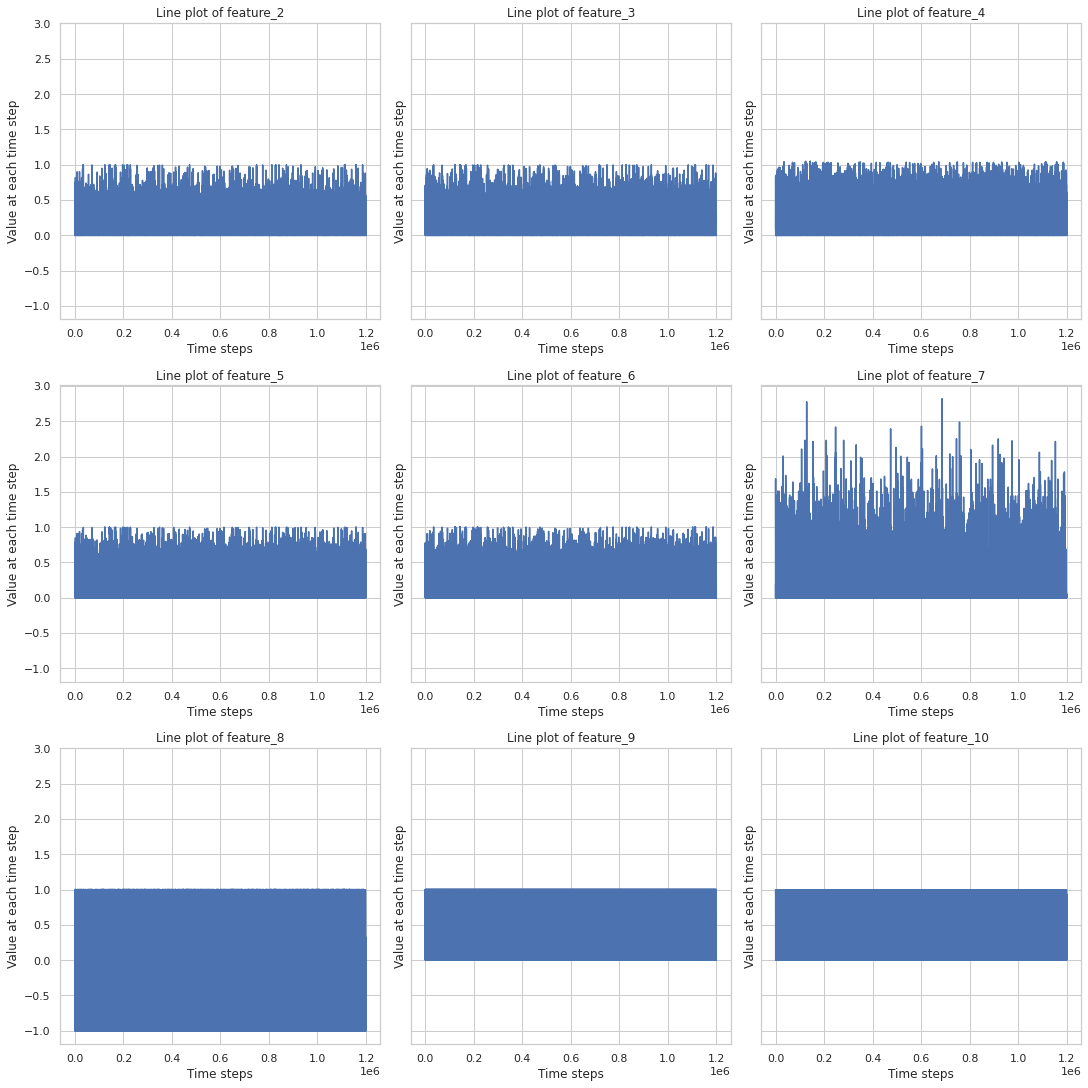

<Figure size 1152x1152 with 0 Axes>

In [ ]:
fig, ax= plt.subplots(3, 3, constrained_layout=True, sharey=True,figsize=(15,15))
fig = plt.figure(figsize = (16, 16))
ax[0][0].plot(total_reset_index['feature_2'])
ax[0][0].set_title('Line plot of feature_2')
ax[0][0].set_xlabel('Time steps')
ax[0][0].set_ylabel('Value at each time step')
ax[0][1].plot(total_reset_index['feature_3'])
ax[0][1].set_title('Line plot of feature_3')
ax[0][1].set_xlabel('Time steps')
ax[0][1].set_ylabel('Value at each time step')
ax[0][2].plot(total_reset_index['feature_4'])
ax[0][2].set_title('Line plot of feature_4')
ax[0][2].set_xlabel('Time steps')
ax[0][2].set_ylabel('Value at each time step')
ax[1][0].plot(total_reset_index['feature_5'])
ax[1][0].set_title('Line plot of feature_5')
ax[1][0].set_xlabel('Time steps')
ax[1][0].set_ylabel('Value at each time step')
ax[1][1].plot(total_reset_index['feature_6'])
ax[1][1].set_title('Line plot of feature_6')
ax[1][1].set_xlabel('Time steps')
ax[1][1].set_ylabel('Value at each time step')
ax[1][2].plot(total_reset_index['feature_7'])
ax[1][2].set_title('Line plot of feature_7')
ax[1][2].set_xlabel('Time steps')
ax[1][2].set_ylabel('Value at each time step')
ax[2][0].plot(total_reset_index['feature_8'])
ax[2][0].set_title('Line plot of feature_8')
ax[2][0].set_xlabel('Time steps')
ax[2][0].set_ylabel('Value at each time step')
ax[2][1].plot(total_reset_index['feature_9'])
ax[2][1].set_title('Line plot of feature_9')
ax[2][1].set_xlabel('Time steps')
ax[2][1].set_ylabel('Value at each time step')
ax[2][2].plot(total_reset_index['feature_10'])
ax[2][2].set_title('Line plot of feature_10')
ax[2][2].set_xlabel('Time steps')
ax[2][2].set_ylabel('Value at each time step')

In [90]:
#Plotting correlation matrix
corr = total_reset_index.corr()
corr.style.background_gradient(cmap='coolwarm')

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
feature_1,1.000000,-0.173977,-0.170746,-0.152642,-0.161671,-0.162257,0.043342,-0.142456,0.235726,0.183891
feature_2,-0.173977,1.000000,0.969900,0.898184,0.931326,0.930569,0.024074,-0.108875,0.088447,-0.014780
feature_3,-0.170746,0.969900,1.000000,0.764100,0.905540,0.900302,0.029700,-0.098676,0.082330,-0.008221
feature_4,-0.152642,0.898184,0.764100,1.000000,0.832448,0.839898,0.010158,-0.110285,0.085677,-0.024312
feature_5,-0.161671,0.931326,0.905540,0.832448,1.000000,0.733330,0.022849,-0.102704,0.081637,-0.006878
feature_6,-0.162257,0.930569,0.900302,0.839898,0.733330,1.000000,0.021972,-0.100002,0.083046,-0.020677
feature_7,0.043342,0.024074,0.029700,0.010158,0.022849,0.021972,1.000000,0.267719,-0.007014,-0.145415
feature_8,-0.142456,-0.108875,-0.098676,-0.110285,-0.102704,-0.100002,0.267719,1.000000,-0.453407,-0.607530
feature_9,0.235726,0.088447,0.082330,0.085677,0.081637,0.083046,-0.007014,-0.453407,1.000000,0.372147
feature_10,0.183891,-0.014780,-0.008221,-0.024312,-0.006878,-0.020677,-0.145415,-0.607530,0.372147,1.000000


The above graph explains the trends of overall line graph and from this line graph we can interpret that, 


*   Features 2, 3, 4, 5, 6 has some variation bettern the points
*   Feature 7 has maximum deviation between the points 


*   Feature 8, 9, 10 are almost consistant. The Feature 8 is varying between -1 to 1, Feature 9, 10 is almost near to 1 consistanly  



*   From the correlation matrix it is found that feature 2 is highly correlated with feature 3 with about 0.96 followed by feature 5, 6 about 0.90


But it is better we some check induvidual labels i.e. 0 and 1 to get better understanding




In [13]:
#Grouping the dataset as per classes (0 and 1) to analyse the features that are important for predecting the model.
df_csv_ones=df_csv[df_csv['selected_event']==1]
df_csv_zeros=df_csv[df_csv['selected_event']==0]
print('The data set has been divides according to their class labels')

The data set has been divides according to their class labels


In [14]:
# getting indices of class 0 and class 1
index = df_csv.index
# applying the conditions for each class
condition_1 = df_csv['selected_event'] ==1
condition_0=df_csv['selected_event']==0
#getting their index 
ones_indices = index[condition_1]
zeros_indices=index[condition_0]
#saving their index in corresponding list
ones_indices_list = ones_indices.tolist()
zeros_indices_list=zeros_indices.tolist()
print('The index for class lables has been sucesfully copied into their corresponding variables')

The index for class lables has been sucesfully copied into their corresponding variables


In [15]:
#Dividing dataset as per the class labels
train_samples_ones=np.array(pickle_lst)[ones_indices_list]
train_samples_zeros=np.array(pickle_lst)[zeros_indices_list]
print('Training samples for class lables has been sucessfully created')
print('The train samples for 0 class:',train_samples_ones.shape)
print('The train samples for 1 class:',train_samples_zeros.shape)

Training samples for class lables has been sucessfully created
The train samples for 0 class: (225, 600, 10)
The train samples for 1 class: (1775, 600, 10)


In [16]:
# Converting the class label 1 training samples into dataframe for analying the trends
total_df_ones=pd.DataFrame(columns=features)
for elm in range(len(train_samples_ones)):
  total=pd.DataFrame(train_samples_ones[elm],columns=features)
  total_df_ones= pd.concat([total_df_ones,total])
print('The dataframe of class label 1 has been sucessfully created')
print('The dataframe shape of class label 1:', total_df_ones.shape)

The dataframe of class label 1 has been sucessfully created
The dataframe shape of class label 1: (135000, 10)


In [17]:
# Converting the class label 0 training samples into dataframe for analying the trends
total_df_zeros=pd.DataFrame(columns=features)
for elm in range(len(train_samples_zeros)):
  total=pd.DataFrame(train_samples_zeros[elm],columns=features)
  total_df_zeros= pd.concat([total_df_zeros,total])
print('The dataframe of class label 0 has been sucessfully created')
print('The dataframe shape of class label 0:', total_df_zeros.shape)

The dataframe of class label 0 has been sucessfully created
The dataframe shape of class label 0: (1065000, 10)


### Ploting the distribution of every features in dataframe of class label '1'

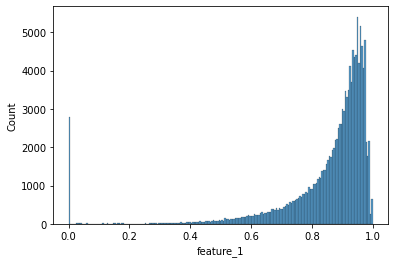

In [ ]:
#Histogram of feature 1  (As density plot is deprecating sooner thereby I have opted for histplot)
sns.histplot(total_df_ones['feature_1'])

The plots has been sucessfully created for class label 1


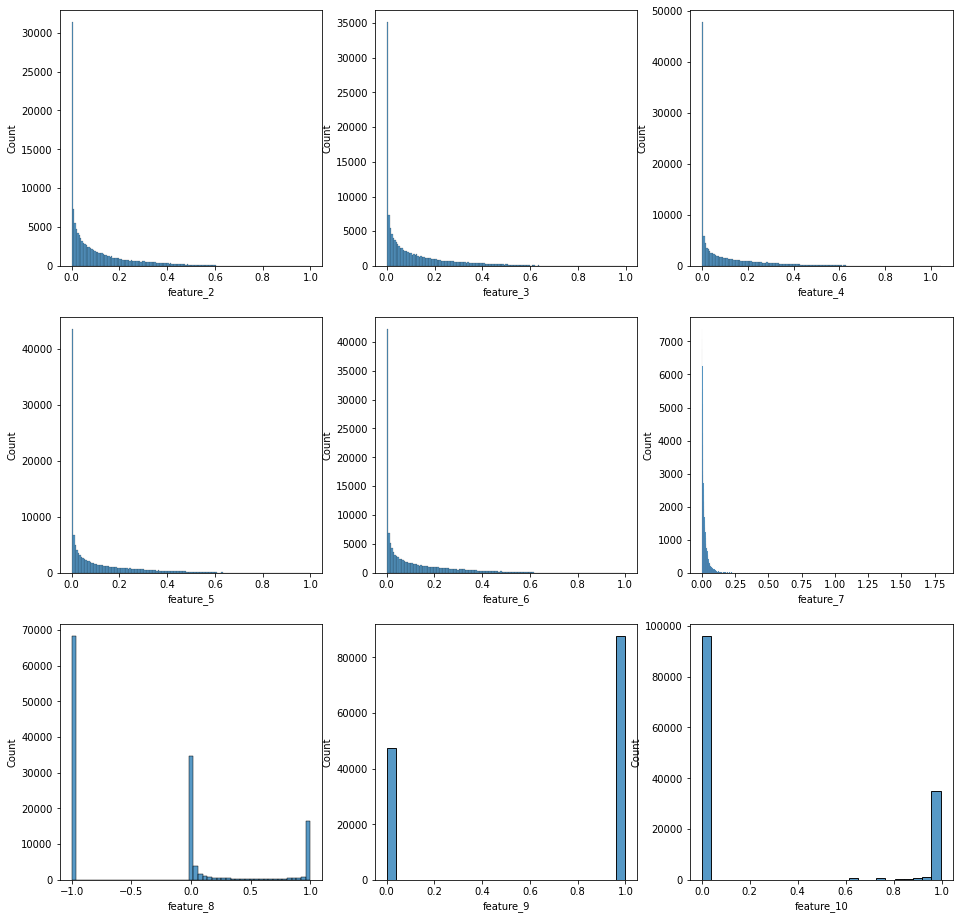

In [ ]:
# Histplot for all faetures belonging to class 1
fig, axes = plt.subplots(3, 3,figsize=(16, 16))
sns.histplot(total_df_ones['feature_2'],ax = axes[0][0])
sns.histplot(total_df_ones['feature_3'],ax = axes[0][1])
sns.histplot(total_df_ones['feature_4'],ax = axes[0][2])
sns.histplot(total_df_ones['feature_5'],ax = axes[1][0])
sns.histplot(total_df_ones['feature_6'],ax = axes[1][1])
sns.histplot(total_df_ones['feature_7'],ax = axes[1][2])
sns.histplot(total_df_ones['feature_8'],ax = axes[2][0])
sns.histplot(total_df_ones['feature_9'],ax = axes[2][1])
sns.histplot(total_df_ones['feature_10'],ax = axes[2][2])
print('The plots has been sucessfully created for class label 1')

*   From the above histograms belonging to class 1, it is observed that (feature 2, feature 3)  and (feature 4, feature 5, feature 6) has similar kind of distribution 
*   Where as feature 1,8,9,10 has different kind of distribution 
*   As zeros and ones features (1,8,9,10) has almost similar kind of profile thereby it is very much difficult to predict the class lable 0 because contrubition of other feature (2,3,4,5,6) helps in determining the class label

1.   Feature 8 has mojority of value focusing at -1
2.   Feature 9 has mojority of value focusing at 1 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

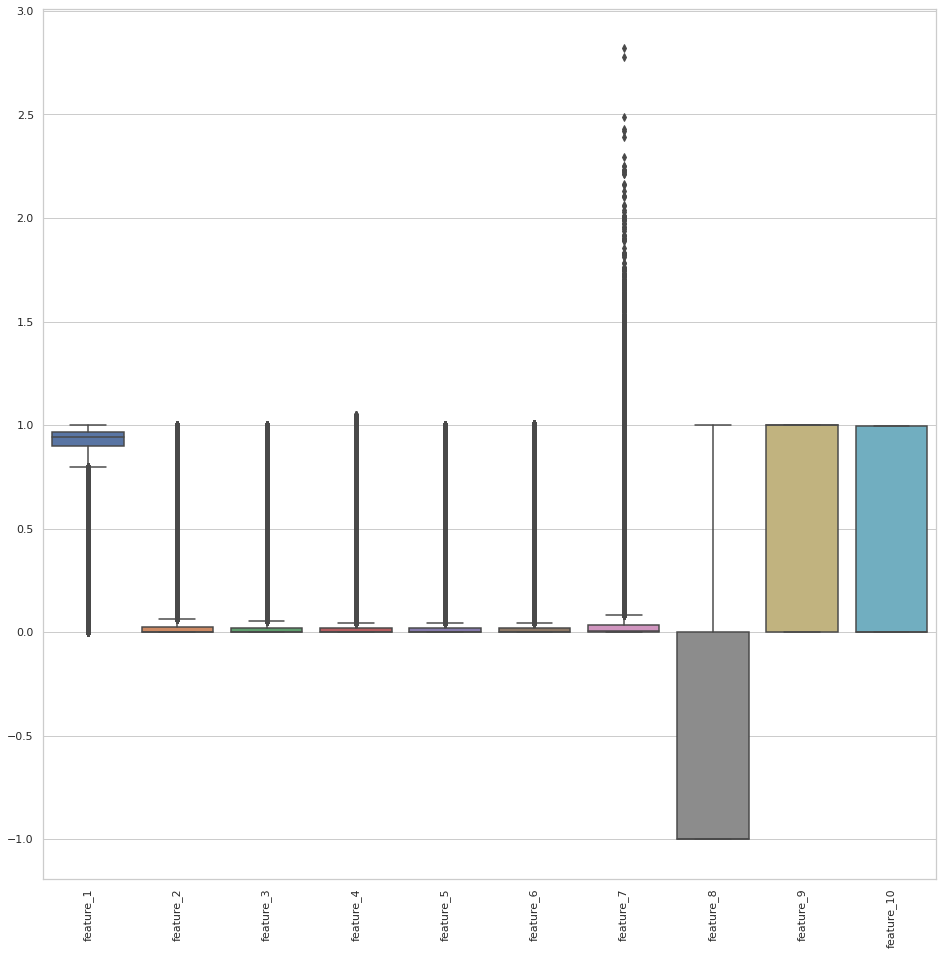

In [ ]:
fig = plt.figure(figsize = (16, 16))
sns.boxplot(data=total_df_zeros)
plt.xticks(rotation = 'vertical')

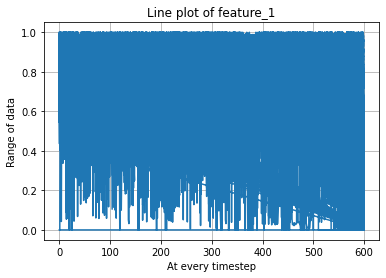

In [ ]:
total_df_ones['feature_1'].plot()
plt.xlabel("At every timestep")
plt.ylabel("Range of data")
plt.title("Line plot of feature_1")
plt.grid(b=None)
plt.show()

Text(0, 0.5, 'Value at each time step')

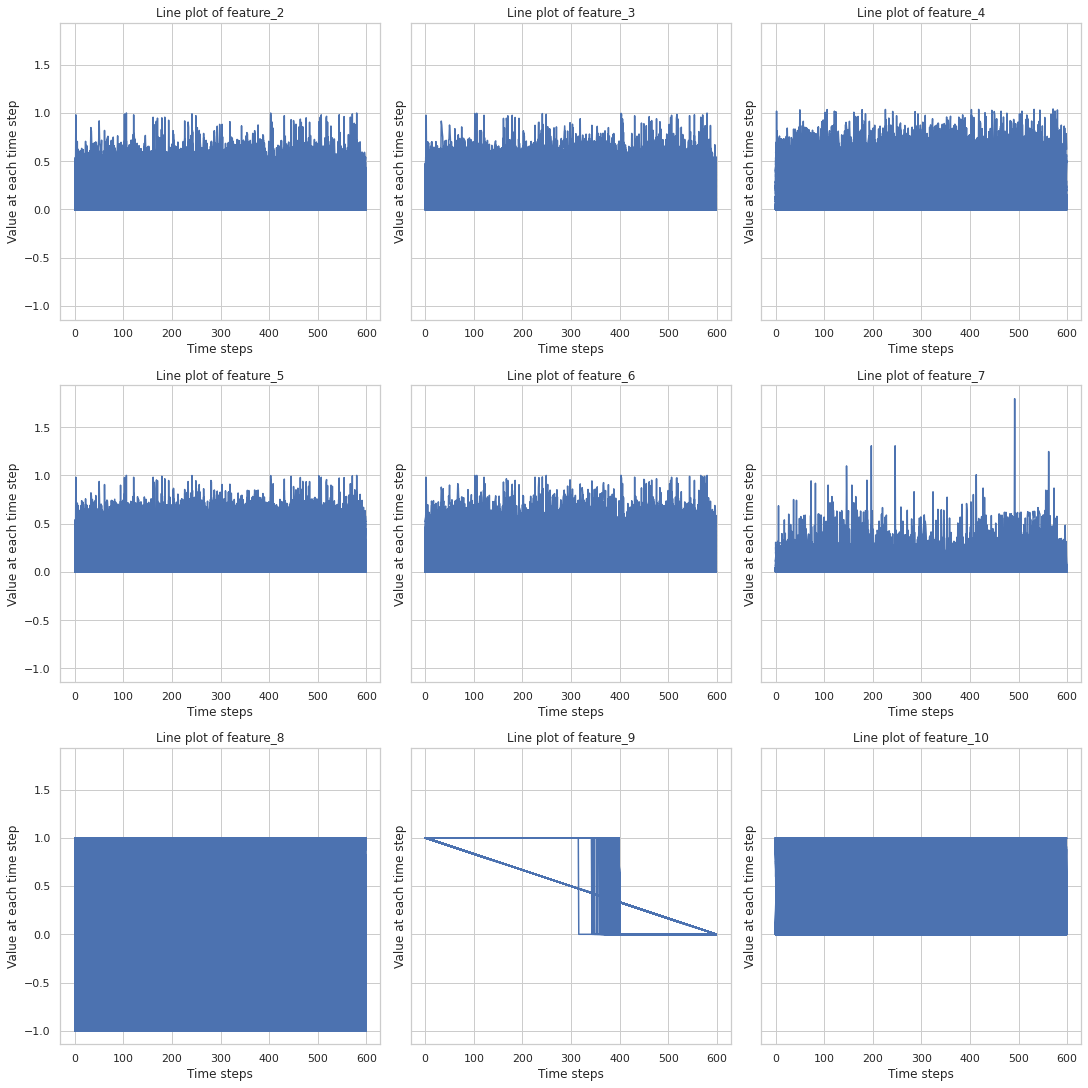

<Figure size 1152x1152 with 0 Axes>

In [ ]:
fig, ax= plt.subplots(3, 3, constrained_layout=True, sharey=True,figsize=(15,15))
fig = plt.figure(figsize = (16, 16))
ax[0][0].plot(total_df_ones['feature_2'])
ax[0][0].set_title('Line plot of feature_2')
ax[0][0].set_xlabel('Time steps')
ax[0][0].set_ylabel('Value at each time step')
ax[0][1].plot(total_df_ones['feature_3'])
ax[0][1].set_title('Line plot of feature_3')
ax[0][1].set_xlabel('Time steps')
ax[0][1].set_ylabel('Value at each time step')
ax[0][2].plot(total_df_ones['feature_4'])
ax[0][2].set_title('Line plot of feature_4')
ax[0][2].set_xlabel('Time steps')
ax[0][2].set_ylabel('Value at each time step')
ax[1][0].plot(total_df_ones['feature_5'])
ax[1][0].set_title('Line plot of feature_5')
ax[1][0].set_xlabel('Time steps')
ax[1][0].set_ylabel('Value at each time step')
ax[1][1].plot(total_df_ones['feature_6'])
ax[1][1].set_title('Line plot of feature_6')
ax[1][1].set_xlabel('Time steps')
ax[1][1].set_ylabel('Value at each time step')
ax[1][2].plot(total_df_ones['feature_7'])
ax[1][2].set_title('Line plot of feature_7')
ax[1][2].set_xlabel('Time steps')
ax[1][2].set_ylabel('Value at each time step')
ax[2][0].plot(total_df_ones['feature_8'])
ax[2][0].set_title('Line plot of feature_8')
ax[2][0].set_xlabel('Time steps')
ax[2][0].set_ylabel('Value at each time step')
ax[2][1].plot(total_df_ones['feature_9'])
ax[2][1].set_title('Line plot of feature_9')
ax[2][1].set_xlabel('Time steps')
ax[2][1].set_ylabel('Value at each time step')
ax[2][2].plot(total_df_ones['feature_10'])
ax[2][2].set_title('Line plot of feature_10')
ax[2][2].set_xlabel('Time steps')
ax[2][2].set_ylabel('Value at each time step')

In [91]:
#Plotting correlation matrix
corr = total_df_ones.corr()
corr.style.background_gradient(cmap='coolwarm')

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
feature_1,1.000000,-0.369662,-0.358491,-0.324652,-0.346221,-0.339023,-0.186925,0.044090,0.108840,0.030251
feature_2,-0.369662,1.000000,0.967465,0.882545,0.928011,0.925821,0.306748,-0.204741,0.123164,0.053723
feature_3,-0.358491,0.967465,1.000000,0.734861,0.900997,0.892475,0.298301,-0.202393,0.119425,0.064903
feature_4,-0.324652,0.882545,0.734861,1.000000,0.813102,0.823073,0.267870,-0.172678,0.108198,0.023387
feature_5,-0.346221,0.928011,0.900997,0.813102,1.000000,0.718361,0.290978,-0.190073,0.113345,0.051106
feature_6,-0.339023,0.925821,0.892475,0.823073,0.718361,1.000000,0.277589,-0.189482,0.114993,0.048470
feature_7,-0.186925,0.306748,0.298301,0.267870,0.290978,0.277589,1.000000,-0.082714,0.023339,0.045707
feature_8,0.044090,-0.204741,-0.202393,-0.172678,-0.190073,-0.189482,-0.082714,1.000000,-0.437298,-0.571638
feature_9,0.108840,0.123164,0.119425,0.108198,0.113345,0.114993,0.023339,-0.437298,1.000000,0.294532
feature_10,0.030251,0.053723,0.064903,0.023387,0.051106,0.048470,0.045707,-0.571638,0.294532,1.000000


***Conclusion from correlation matrix, box plot and line plots for class lable '1'***

From the line graph it is observed that 

*   Features 2, 3, 4, 5, 6 has fluctuation between 0 and 1 
*   Features 8, 9 almost every value is close to 1

*   But unlike other features, feature 7 has different trend it has high fluactions and there are few values which is above 1.5

*   feature 2 and feature 3 are highly correlated with 0.96 followed by feature 5, 6 about 0.92

### Ploting the distribution of every features in dataframe of class label '0'

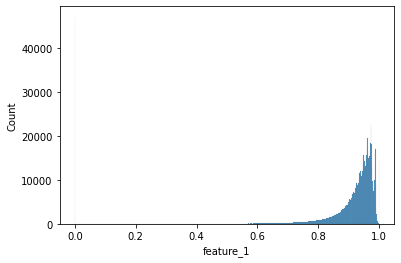

In [ ]:
#Hisplot for feature 1 belonging to class label 0
sns.histplot(total_df_zeros['feature_1'])

The plots has been sucessfully created for class label 0


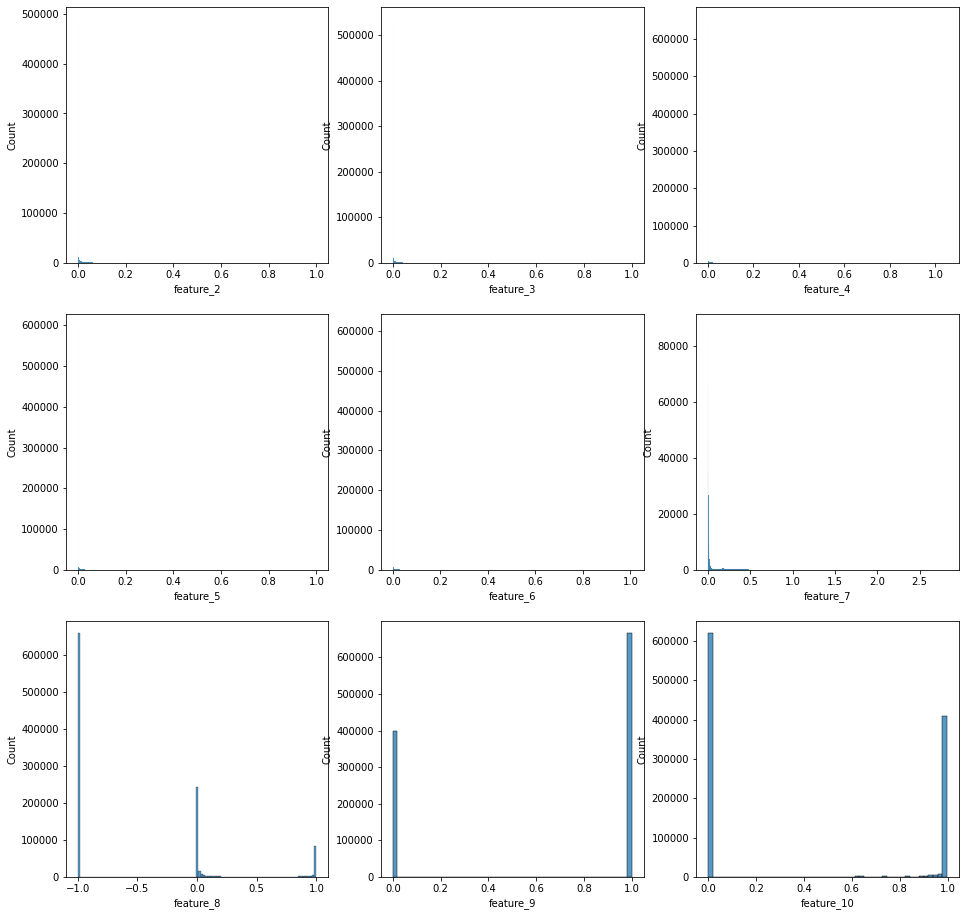

In [ ]:
# Histplot for all faetures belonging to class 1
fig, axes = plt.subplots(3, 3,figsize=(16, 16))
sns.histplot(total_df_zeros['feature_2'],ax = axes[0][0])
sns.histplot(total_df_zeros['feature_3'],ax = axes[0][1])
sns.histplot(total_df_zeros['feature_4'],ax = axes[0][2])
sns.histplot(total_df_zeros['feature_5'],ax = axes[1][0])
sns.histplot(total_df_zeros['feature_6'],ax = axes[1][1])
sns.histplot(total_df_zeros['feature_7'],ax = axes[1][2])
sns.histplot(total_df_zeros['feature_8'],ax = axes[2][0])
sns.histplot(total_df_zeros['feature_9'],ax = axes[2][1])
sns.histplot(total_df_zeros['feature_10'],ax = axes[2][2])
print('The plots has been sucessfully created for class label 0')

*   By looking at the above histogram plots belonging to class 0, it is every much evident that only features 1,8,9, 10 plays a important role in identifying the class label 1
*   Unlike class label 0 it is very much easy to predict the class l as only feature (1,8,9,10) are contributing for predection

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

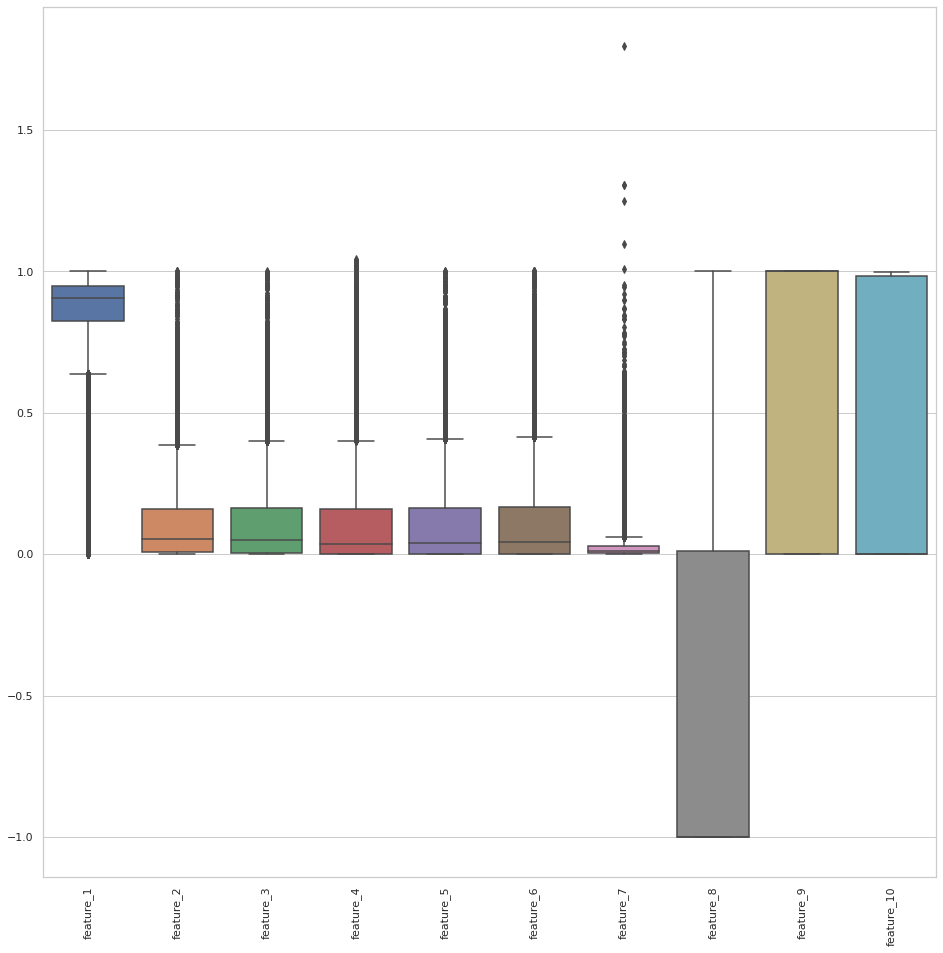

In [ ]:
fig = plt.figure(figsize = (16, 16))
sns.boxplot(data=total_df_ones)
plt.xticks(rotation = 'vertical')

Text(0, 0.5, 'Value at each time step')

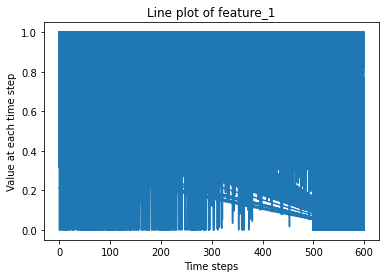

In [ ]:
#plotting line graph for feature 1 (only with class lable 1 )
total_df_zeros['feature_1'].plot()
plt.title('Line plot of feature_1')
plt.xlabel('Time steps')
plt.ylabel('Value at each time step')

Text(0, 0.5, 'Value at each time step')

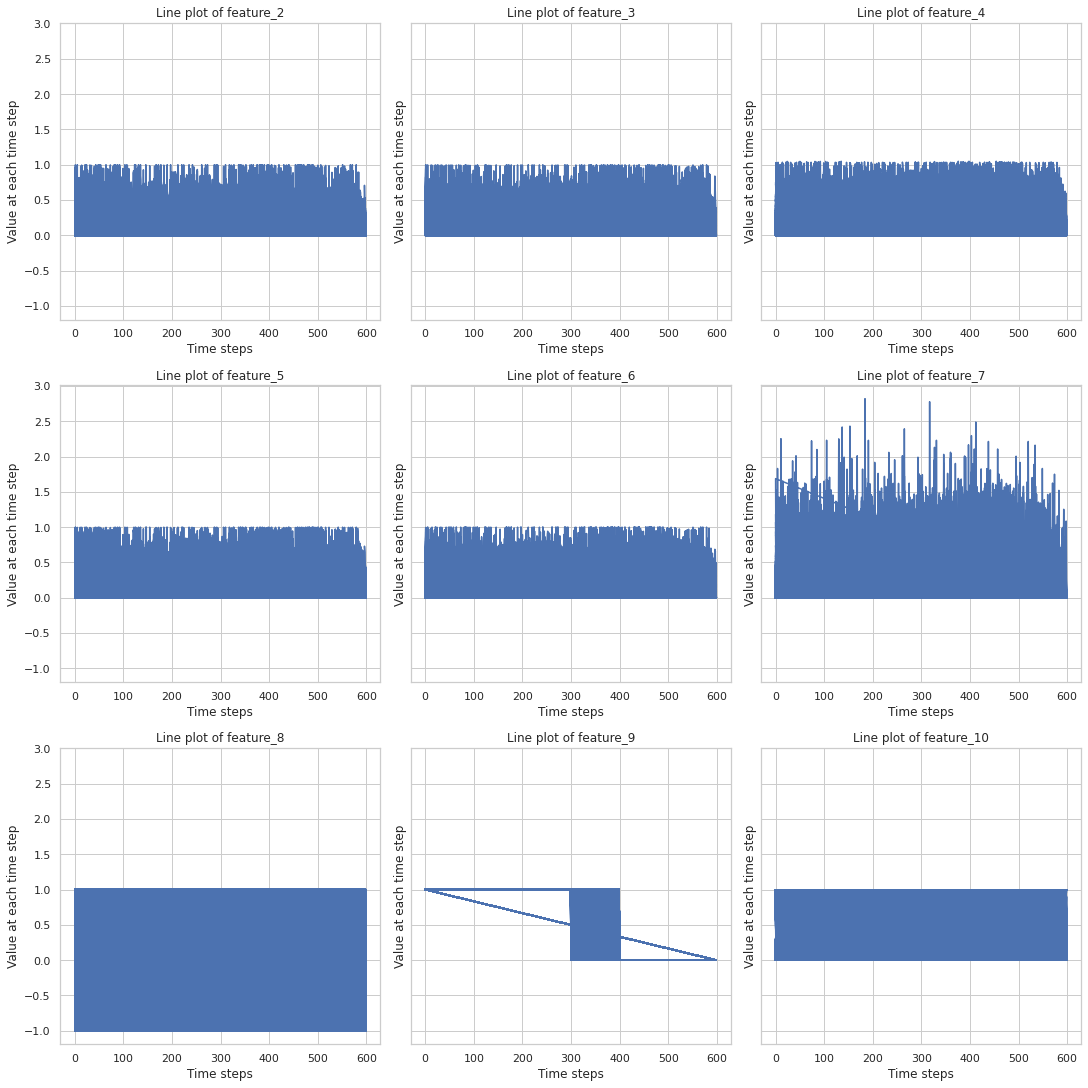

<Figure size 1152x1152 with 0 Axes>

In [ ]:
#plotting line graph for feature 2 to 10 (only with class lable 1 )
fig, ax= plt.subplots(3, 3, constrained_layout=True, sharey=True,figsize=(15,15))
ax[0][0].plot(total_df_zeros['feature_2'])
ax[0][0].set_title('Line plot of feature_2')
ax[0][0].set_xlabel('Time steps')
ax[0][0].set_ylabel('Value at each time step')
ax[0][1].plot(total_df_zeros['feature_3'])
ax[0][1].set_title('Line plot of feature_3')
ax[0][1].set_xlabel('Time steps')
ax[0][1].set_ylabel('Value at each time step')
ax[0][2].plot(total_df_zeros['feature_4'])
ax[0][2].set_title('Line plot of feature_4')
ax[0][2].set_xlabel('Time steps')
ax[0][2].set_ylabel('Value at each time step')
ax[1][0].plot(total_df_zeros['feature_5'])
ax[1][0].set_title('Line plot of feature_5')
ax[1][0].set_xlabel('Time steps')
ax[1][0].set_ylabel('Value at each time step')
ax[1][1].plot(total_df_zeros['feature_6'])
ax[1][1].set_title('Line plot of feature_6')
ax[1][1].set_xlabel('Time steps')
ax[1][1].set_ylabel('Value at each time step')
ax[1][2].plot(total_df_zeros['feature_7'])
ax[1][2].set_title('Line plot of feature_7')
ax[1][2].set_xlabel('Time steps')
ax[1][2].set_ylabel('Value at each time step')
ax[2][0].plot(total_df_zeros['feature_8'])
ax[2][0].set_title('Line plot of feature_8')
ax[2][0].set_xlabel('Time steps')
ax[2][0].set_ylabel('Value at each time step')
ax[2][1].plot(total_df_zeros['feature_9'])
ax[2][1].set_title('Line plot of feature_9')
ax[2][1].set_xlabel('Time steps')
ax[2][1].set_ylabel('Value at each time step')
ax[2][2].plot(total_df_zeros['feature_10'])
ax[2][2].set_title('Line plot of feature_10')
ax[2][2].set_xlabel('Time steps')
ax[2][2].set_ylabel('Value at each time step')

In [92]:
#Plotting correlation matrix
corr = total_df_zeros.corr()
corr.style.background_gradient(cmap='coolwarm')

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
feature_1,1.000000,-0.136752,-0.134408,-0.119005,-0.125628,-0.127728,0.047066,-0.161036,0.250611,0.195427
feature_2,-0.136752,1.000000,0.967871,0.896608,0.926603,0.926029,0.041418,-0.120861,0.082129,-0.001444
feature_3,-0.134408,0.967871,1.000000,0.756454,0.898939,0.894162,0.048907,-0.108098,0.075131,0.004597
feature_4,-0.119005,0.896608,0.756454,1.000000,0.827089,0.834009,0.021604,-0.124002,0.081315,-0.011852
feature_5,-0.125628,0.926603,0.898939,0.827089,1.000000,0.716124,0.038048,-0.113261,0.075353,0.006827
feature_6,-0.127728,0.926029,0.894162,0.834009,0.716124,1.000000,0.038686,-0.110645,0.076805,-0.009533
feature_7,0.047066,0.041418,0.048907,0.021604,0.038048,0.038686,1.000000,0.304653,-0.006739,-0.166643
feature_8,-0.161036,-0.120861,-0.108098,-0.124002,-0.113261,-0.110645,0.304653,1.000000,-0.458977,-0.610121
feature_9,0.250611,0.082129,0.075131,0.081315,0.075353,0.076805,-0.006739,-0.458977,1.000000,0.384091
feature_10,0.195427,-0.001444,0.004597,-0.011852,0.006827,-0.009533,-0.166643,-0.610121,0.384091,1.000000


**Conclusion from box plot and line plots for class lable 0**
*   From the above box plot it is very much evident that feature 7 contains few outliers and feature 8 values are ranging between 0 and -1
*   In case of line graph feature 7 has many values more than 1, Then by we can conclude that feature 7 is most critical in finding out the class label. 


*   feature 2 is highly correlated with feature 3 with correlation factor of 0.96, followed by feature 5, 6 with about 0.92 


*   In both the class labels feature 2 and feature 3 are highly correlated there by we can eliminated faeture 2 if we want to reduce the dimensionality of the dataset(curse of dimensionality can be reduced)





## Preprocessing

In [19]:
# Converting the dataset into a numpy array for feeding into standardscale for making feature values ranging between 0 to 1
total_df_numpy=total_reset_index.to_numpy()
print('The numpy array for complete dataset has been created')
print('The shape of total numpy array is :', total_df_numpy.shape)

The numpy array for complete dataset has been created
The shape of total numpy array is : (1200000, 10)


In [21]:
#Conveting labels into an array therefore it can be fed into model
labels=df_csv['selected_event'].tolist()
labels_array=np.asarray(labels)
print('The shape of labels is', labels_array.shape)

The shape of labels is (2000,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
data_std_minmax= MinMaxScaler().fit_transform(total_df_numpy)
print('The standardization has been sucessfully performed on all the features to bring down the values between 0 and 1 ')
#Conformance checking shape
print('The shape of dataset after standardizing', data_std_minmax.shape)

The standardization has been sucessfully performed on all the features to bring down the values between 0 and 1 
The shape of dataset after standardizing (1200000, 10)


In [ ]:
from sklearn.preprocessing import StandardScaler
data_std_standardscaler = StandardScaler(with_mean=False).fit_transform(total_df_numpy)
print('The standardization has been sucessfully performed on all the features to have uniformity between features')
#Conformance checking shape
print('The shape of dataset after standardizing', data_std_standardscaler.shape)

The standardization has been sucessfully performed on all the features to have uniformity between features
The shape of dataset after standardizing (1200000, 10)


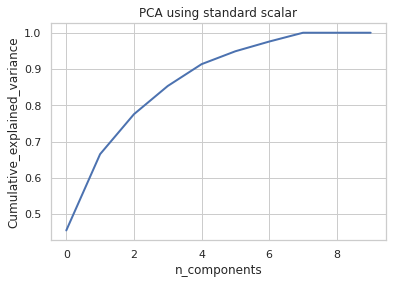

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.n_components = data_std_standardscaler.shape[1]
pca_data = pca.fit_transform(data_std_standardscaler)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)

plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid(b=True)
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.title('PCA using standard scalar')
plt.show()

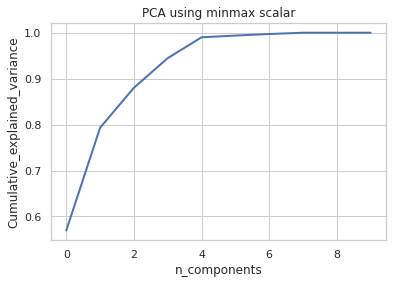

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.n_components = data_std_minmax.shape[1]
pca_data = pca.fit_transform(data_std_minmax)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)

plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid(b=True)
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.title('PCA using minmax scalar')
plt.show()

Principle component analysis has been performed on complete dataset to see how many features can contribute the percentage of totalpercentage of variance in the higher dimesion



*   By using Minmax scalar using 4 feature about 95% variance of the orginal dataset can be explined 
*   By using standard scalar using 6 features about 95% variance of the orginal dataset can be explained



In [22]:
from sklearn.model_selection import train_test_split
total_df_ndarray=np.reshape(total_df_numpy,(2000,600,10))
print('The shape of input X is: ', total_df_ndarray.shape)
print('The shape of input y is: ', labels_array.shape)
X_train, X_test, y_train, y_test = train_test_split(total_df_ndarray, labels_array, test_size=0.30, random_state=42)
#Conformance checking
print('The shape of X_train is: ',X_train.shape)
print('The shape of X_test is: ',X_test.shape)
print('The shape of y_train is: ', y_train.shape)
print('The shape of y_train is: ', y_test.shape)

The shape of input X is:  (2000, 600, 10)
The shape of input y is:  (2000,)
The shape of X_train is:  (1400, 600, 10)
The shape of X_test is:  (600, 600, 10)
The shape of y_train is:  (1400,)
The shape of y_train is:  (600,)


In [23]:
#converting X_train array into a dataframe
X_train_pd=pd.DataFrame(columns=features)
for elm in range(len(X_train)):
  total=pd.DataFrame(X_train[elm],columns=features)
  X_train_pd= pd.concat([X_train_pd,total])
print('The dataset is sucessfully prepared and read to use')
print('The dataset contains {} rows and {} columns'.format(X_train_pd.shape[0],X_train_pd.shape[1]))

The dataset is sucessfully prepared and read to use
The dataset contains 840000 rows and 10 columns


In [24]:
#converting X_test array into a dataframe
X_test_pd=pd.DataFrame(columns=features)
for elm in range(len(X_test)):
  total=pd.DataFrame(X_test[elm],columns=features)
  X_test_pd= pd.concat([X_test_pd,total])
print('The dataset is sucessfully prepared and read to use')
print('The dataset contains {} rows and {} columns'.format(X_test_pd.shape[0],X_test_pd.shape[1]))

The dataset is sucessfully prepared and read to use
The dataset contains 360000 rows and 10 columns


In [25]:
#Converting into numpy array for X_train and X_test
X_train_numpy=X_train_pd.to_numpy()
X_test_numpy=X_test_pd.to_numpy()
print('The array for X_train and X_test has been sucessfully created')
print('The shape of X_train_numpy is: ', X_train_numpy.shape )
print('The shape of X_test_numpy is: ', X_test_numpy.shape )

The array for X_train and X_test has been sucessfully created
The shape of X_train_numpy is:  (840000, 10)
The shape of X_test_numpy is:  (360000, 10)


In [26]:
#Normalizing the feature for X_train and X_test
mean = np.mean(X_train_numpy, axis=0)
X_train_numpy -= mean
X_test_numpy -= mean
std = np.std(X_train_numpy, axis=0)
X_train_numpy /= std
X_test_numpy /= std

In [ ]:
print('The standardization has been sucessfully performed')
print('The shape of X_train_numpy after standardization is: ', X_train_numpy.shape)
print('The shape of X_test_numpy after standardization is: ', X_test_numpy.shape)

The standardization has been sucessfully performed
The shape of X_train_numpy after standardization is:  (840000, 10)
The shape of X_test_numpy after standardization is:  (360000, 10)


In [27]:
#Converting X_train and X_test array to the required format which is accepted by keras model
X_train_ndarray=np.reshape(X_train_numpy,(1400,600,10))
X_test_ndarray=np.reshape(X_test_numpy,(600,600,10))
#For conformance
print('The shape of X_train for keras model is: ', X_train_ndarray.shape)
print('The shape of X_test for keras model is: ', X_test_ndarray.shape)

The shape of X_train for keras model is:  (1400, 600, 10)
The shape of X_test for keras model is:  (600, 600, 10)


In [89]:
# Function for ploting confusion matrix
def plot_confusion_matrix(test_y,predict_y):
    C=confusion_matrix(test_y,predict_y)#Binary Confusion Matrix
    A=(((C.T)/(C.sum(axis=1))).T)#Recall Matrix
    B=(C/C.sum(axis=0))#Precision Matrix
    
    plt.figure(figsize=(20,4))
    labels=[0,1]
    
    cmap=sns.light_palette('blue')
    plt.subplot(1,3,1)
    sns.heatmap(C,annot=True,cmap=cmap,fmt='.3f',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted class')
    plt.ylabel('Orginal class')
    plt.title('Confusion matrix [0:Activity_0, 1:Activity_0]')
    
    plt.subplot(1,3,2)
    sns.heatmap(B,annot=True,cmap=cmap,fmt='.3f',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted class')
    plt.ylabel('Orginal class')
    plt.title('Precision matrix [0:Activity_0, 1:Activity_0]')
    
    plt.subplot(1,3,3)
    sns.heatmap(A,annot=True,cmap=cmap,fmt='.3f',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted class')
    plt.ylabel('Orginal class')
    plt.title('Recall matrix [0:Activity_0, 1:Activity_0]')
    
    plt.show()

In [29]:
#Functions for ploting training and validation loss
def plt_train_val_acc(x,val_acc,train_acc,colors=['b']):
    plt.figure(figsize=(12,6))
    plt.grid()
    plt.plot(x,val_acc,'b',label="Validation Accuracy")
    plt.plot(x,train_acc,'r',label="Train Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy after each epoch')
    plt.legend()
    
def plt_train_val_loss(x,val_loss,train_loss,colors=['b']):
    plt.figure(figsize=(12,6))
    plt.grid()
    plt.plot(x,val_loss,'b',label="Validation Loss")
    plt.plot(x,train_loss,'r',label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel('Binary Crossentropy loss')
    plt.legend()

##Model Training

In [45]:
#Creating variables for model desiging
timesteps = len(pickle_lst[0])
print('The number of timesteps:', timesteps)
input_dim = len(pickle_lst[0][0])
print('The input dimension of input_dim:', input_dim)
n_classes = 1
print('The total number of datapoints/events', len(pickle_lst))

The number of timesteps: 600
The input dimension of input_dim: 10
The total number of datapoints/events 2000


In [33]:
# Defining paramters for training
#As dataset is completly imbalanced therefore we it is necessary to use class weights
epochs = 30
batch_size = 16
n_hidden = 32
neg=value[0]
pos=value[1]
total=neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.56
Weight for class 1: 4.44


As the model is completly imbalanaced it is very much necessary to have a right class weights with respect to train the model.

In [35]:
# Model Desigining
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim),return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(64))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 600, 32)           5504      
_________________________________________________________________
dropout (Dropout)            (None, 600, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


**There are only 2000 events thereby model has to designed as simple as possible cause it is very easy model to overfit** Thereby only two LSTM layers has been considred with a dropout layer inbetween them.

In [36]:
# Metrics
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

As the dataset is completly imbalanaced, thereby accuarcy can't not be a right metric. Therefore we need to use Precission, recall, f1 score(combination of precission and recall) or AUC inorder to check the performance of the model.

In [ ]:
#Callbacks
early_stopping_cb= tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True) 
checkpointing_cb=tf.keras.callbacks.ModelCheckpoint('model_ckpt.h5') #checkpointing if there is any disruption while training
callbacks=[early_stopping_cb,checkpointing_cb]

In [ ]:
history=model.fit(x=X_train_ndarray,y=y_train,batch_size=batch_size,
          validation_data=(X_test_ndarray, y_test), epochs=epochs,class_weight=class_weight,callbacks=callbacks)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
88/88 [==============================] - 68s 522ms/step - loss: 0.6283 - fn: 13.5107 - fp: 98.2351 - tn: 230.0332 - tp: 26.1291 - precision: 0.1835 - recall: 0.5486 - val_loss: 0.3825 - val_fn: 56.3947 - val_fp: 328.1579 - val_tn: 1190.8422 - val_tp: 136.3947 - val_precision: 0.2929 - val_recall: 0.7087
Epoch 2/30
88/88 [==============================] - 44s 502ms/step - loss: 0.3917 - fn: 75.0032 - fp: 388.7785 - tn: 1713.3593 - tp: 190.7670 - precision: 0.3282 - recall: 0.7165 - val_loss: 0.3235 - val_fn: 98.0263 - val_fp: 543.9474 - val_tn: 2750.0527 - val_tp: 319.7632 - val_precision: 0.3700 - val_recall: 0.7651
Epoch 3/30
88/88 [==============================] - 44s 504ms/step - loss: 0.3063 - fn: 108.0653 - fp: 613.3612 - tn: 3265.0888 - tp: 381.3928 - precision: 0.3833 - recall: 0.7789 - val_loss: 0.4749 - val_fn: 128.1316 - val_fp:

In [ ]:
# For creating tensorflow log directory
import time
def get_log_path(log_dir='logs/fit'):
  fileName= time.strftime("log_%Y_%m_%d_%H_%M_%S")
  log_path=os.path.join(log_dir, fileName)
  print(f'saving logs at: {log_path}')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [96]:
#creating folder model saving
import time
import os
def saveModel_path(model_dir="TRAINED_MODELS"):
    os.makedirs(model_dir, exist_ok=True)
    fileName = time.strftime("Model_%Y_%m_%d_%H_%M_%S_.h5")    
    model_path = os.path.join(model_dir, fileName)
    print(f"your model will be saved at the following location\n{model_path}")
    return model_path

In [ ]:
#Saving the model in the respective directory
UNIQUE_PATH=saveModel_path()
tf.keras.models.save_model(model,UNIQUE_PATH)

your model will be saved at the following location
TRAINED_MODELS/Model_2021_07_25_08_17_20_.h5


In [ ]:
# Storing the loss and accuracy for every epoch in a dataframe
df_acc_loss=pd.DataFrame(history.history)

In [ ]:
#Visulizing the metric dataset
df_acc_loss

,loss,fn,fp,tn,tp,precision,recall,val_loss,val_fn,val_fp,val_tn,val_tp,val_precision,val_recall
0,0.559640,24.272728,174.295456,460.590912,52.750000,0.217244,0.645489,0.382509,56.394737,328.157898,1190.842163,136.394730,0.292919,0.708684
1,0.370473,81.681816,430.011353,1979.704590,220.511368,0.337607,0.727813,0.323541,98.026314,543.947388,2750.052734,319.763153,0.369957,0.765099
2,0.362186,113.193184,659.329529,3526.659180,412.727264,0.384925,0.784278,0.474931,128.131577,841.526306,4227.473633,514.657898,0.379493,0.800541
3,0.285693,140.522720,974.045471,4985.147949,612.193176,0.385648,0.813062,0.309317,149.868423,1071.368408,5772.631348,717.921082,0.401176,0.827230
4,0.258444,161.704544,1154.352295,6581.647949,814.204529,0.413383,0.834179,0.363811,173.894730,1240.500000,7378.500000,918.894714,0.425515,0.840830
5,0.264481,186.840912,1325.420410,8181.420410,1018.227295,0.434374,0.844954,0.213897,201.973679,1410.552612,8983.447266,1115.815796,0.441641,0.846737
6,0.385463,220.579544,1539.738647,9745.511719,1206.079590,0.439483,0.845391,0.407345,231.921051,1683.921021,10485.079102,1310.868408,0.437714,0.849656
7,0.413606,248.102280,1814.204590,11241.659180,1407.943237,0.436992,0.850192,0.242673,263.105255,1944.710571,11999.289062,1504.684204,0.436209,0.851181
8,0.331283,278.125000,2065.090820,12771.045898,1597.647705,0.436202,0.851712,0.659998,287.578949,2244.815674,13474.184570,1705.210571,0.431746,0.855675
9,0.269745,294.250000,2401.727295,14204.011719,1811.920410,0.429980,0.860279,0.284168,308.973694,2474.578857,15019.420898,1908.815796,0.435456,0.860687


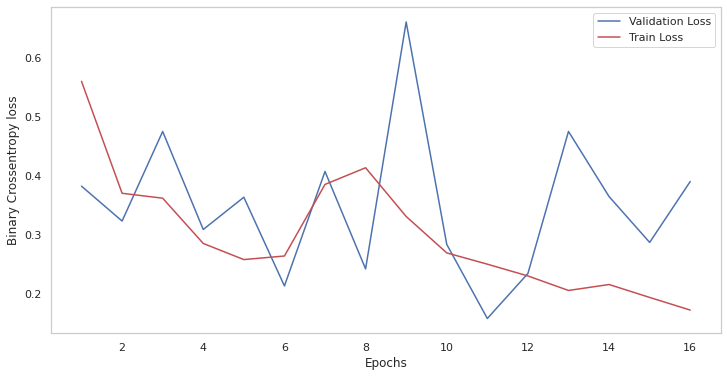

In [ ]:
# ploting binary loss for both training and testing test
x=list(range(1,17))
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(x,df_acc_loss['val_loss'],'b',label="Validation Loss")
plt.plot(x,df_acc_loss['loss'],'r',label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel('Binary Crossentropy loss')
plt.legend()

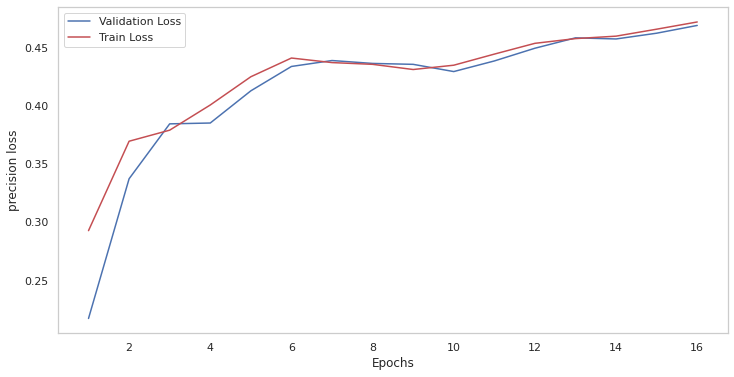

In [ ]:
# ploting Precision loss for both training and testing test
x=list(range(1,17))
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(x,df_acc_loss['precision'],'b',label="Validation Loss")
plt.plot(x,df_acc_loss['val_precision'],'r',label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel('precision loss')
plt.legend()

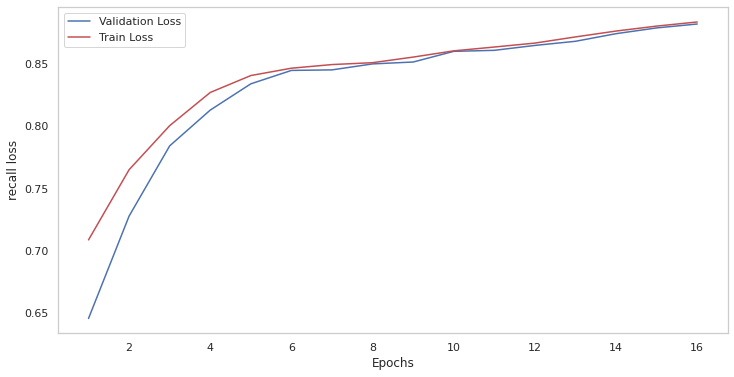

In [ ]:
# ploting Recall loss for both training and testing test
x=list(range(1,17))
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(x,df_acc_loss['recall'],'b',label="Validation Loss")
plt.plot(x,df_acc_loss['val_recall'],'r',label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel('recall loss')
plt.legend()

In [ ]:
#loading the saved model
loaded_model=tf.keras.models.load_model('/content/drive/MyDrive/task/TRAINED_MODELS/Model_2021_07_25_08_17_20_.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


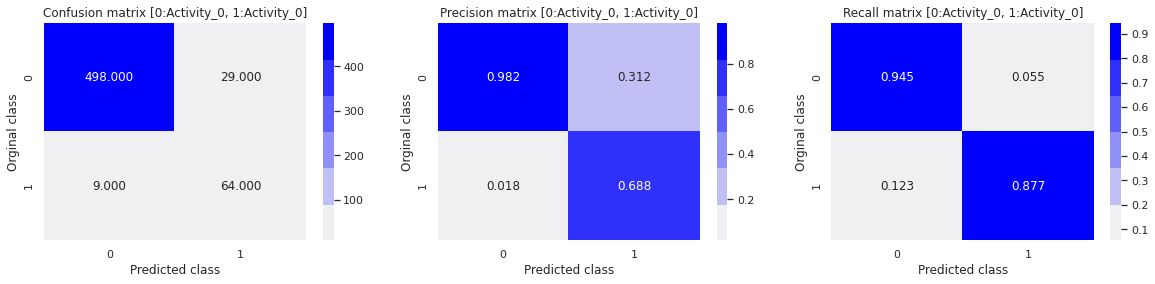

classification report on test(unseen) data

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       527
           1       0.69      0.88      0.77        73

    accuracy                           0.94       600
   macro avg       0.84      0.91      0.87       600
weighted avg       0.95      0.94      0.94       600

Test accuracy on unseen data: 



0.9366666666666666

In [ ]:
y_pred=model.predict_classes(X_test_ndarray,verbose=0)

# plotting Confusion matrix, Precision and Recall

plot_confusion_matrix(y_test,y_pred) # confusion matrix

print('classification report on test(unseen) data\n')  # Precision
print(classification_report(y_test,y_pred))

print('Test accuracy on unseen data: \n') # Recall
accuracy_score(y_test, y_pred)

##Other Model Trainings

In [48]:
# Model Desigining
model_Bi = Sequential()
# Configuring the parameters
model_Bi.add(Bidirectional(LSTM(n_hidden, input_shape=(600, 10),return_sequences=True)))
# Adding a dropout layer
model_Bi.add(Dropout(0.5))
model_Bi.add(Bidirectional(LSTM(64)))
# Adding a dense output layer with sigmoid activation
model_Bi.add(Dense(n_classes, activation='sigmoid'))

In [53]:
model_Bi.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

In [52]:
early_stopping_cb= tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True) 
checkpointing_cb=tf.keras.callbacks.ModelCheckpoint('model_ckpt.h5') #checkpointing if there is any disruption while training
callbacks=[early_stopping_cb,checkpointing_cb]

In [54]:
history_Bi=model_Bi.fit(x=X_train_ndarray,y=y_train,batch_size=batch_size,
          validation_data=(X_test_ndarray, y_test), epochs=epochs,class_weight=class_weight,callbacks=callbacks)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
88/88 [==============================] - 113s 842ms/step - loss: 0.5632 - fn: 11.1482 - fp: 88.8670 - tn: 234.8643 - tp: 33.0285 - precision: 0.2333 - recall: 0.6507 - val_loss: 0.4643 - val_fn: 37.2368 - val_fp: 331.1316 - val_tn: 1187.8684 - val_tp: 155.5526 - val_precision: 0.3202 - val_recall: 0.8062
Epoch 2/30
88/88 [==============================] - 72s 814ms/step - loss: 0.4742 - fn: 51.7103 - fp: 493.1803 - tn: 1609.1802 - tp: 213.8374 - precision: 0.3029 - recall: 0.8058 - val_loss: 0.2340 - val_fn: 73.4737 - val_fp: 717.5263 - val_tn: 2576.4736 - val_tp: 344.3158 - val_precision: 0.3240 - val_recall: 0.8239
Epoch 3/30
88/88 [==============================] - 71s 810ms/step - loss: 0.3056 - fn: 81.5474 - fp: 794.1450 - tn: 3088.1426 - tp: 404.0731 - precision: 0.3371 - recall: 0.8319 - val_loss: 0.4251 - val_fn: 100.0526 - val_fp:

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


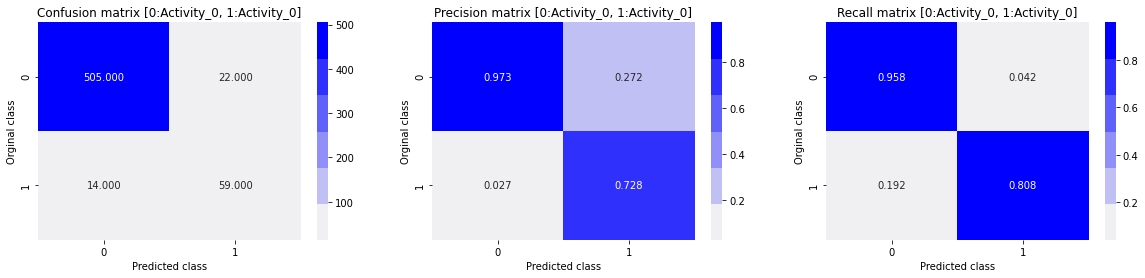

classification report on test(unseen) data

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       527
           1       0.73      0.81      0.77        73

    accuracy                           0.94       600
   macro avg       0.85      0.88      0.87       600
weighted avg       0.94      0.94      0.94       600

Test accuracy on unseen data: 



0.94

In [95]:
y_pred=model_Bi.predict_classes(X_test_ndarray,verbose=0)

# plotting Confusion matrix, Precision and Recall

plot_confusion_matrix(y_test,y_pred) # confusion matrix

print('classification report on test(unseen) data\n')  # Precision
print(classification_report(y_test,y_pred))

print('Test accuracy on unseen data: \n') # Recall
accuracy_score(y_test, y_pred)

In [79]:
model_Bi_1.compile(
    optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=metrics
)

In [80]:
history_Bi_1=model_Bi.fit(x=X_train_ndarray,y=y_train,batch_size=batch_size,
          validation_data=(X_test_ndarray, y_test), epochs=epochs,class_weight=class_weight,callbacks=callbacks)

Epoch 1/30
88/88 [==============================] - 72s 818ms/step - loss: 0.2025 - fn: 599.6364 - fp: 4142.7612 - tn: 33768.6836 - tp: 4200.8296 - precision: 0.5035 - recall: 0.8751 - val_loss: 0.1542 - val_fn: 613.5526 - val_fp: 4205.8423 - val_tn: 34588.1562 - val_tp: 4304.2368 - val_precision: 0.5058 - val_recall: 0.8752
Epoch 2/30
88/88 [==============================] - 72s 814ms/step - loss: 0.2138 - fn: 627.9205 - fp: 4247.1479 - tn: 35434.7148 - tp: 4402.1250 - precision: 0.5090 - recall: 0.8752 - val_loss: 0.1785 - val_fn: 647.4211 - val_fp: 4292.2104 - val_tn: 36276.7891 - val_tp: 4495.3687 - val_precision: 0.5116 - val_recall: 0.8741
Epoch 3/30
88/88 [==============================] - 72s 814ms/step - loss: 0.2363 - fn: 663.8523 - fp: 4340.4434 - tn: 37122.5898 - tp: 4585.0229 - precision: 0.5137 - recall: 0.8735 - val_loss: 0.2031 - val_fn: 676.1842 - val_fp: 4410.3687 - val_tn: 37933.6328 - val_tp: 4691.6055 - val_precision: 0.5154 - val_recall: 0.8740
Epoch 4/30
88/88 [=

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


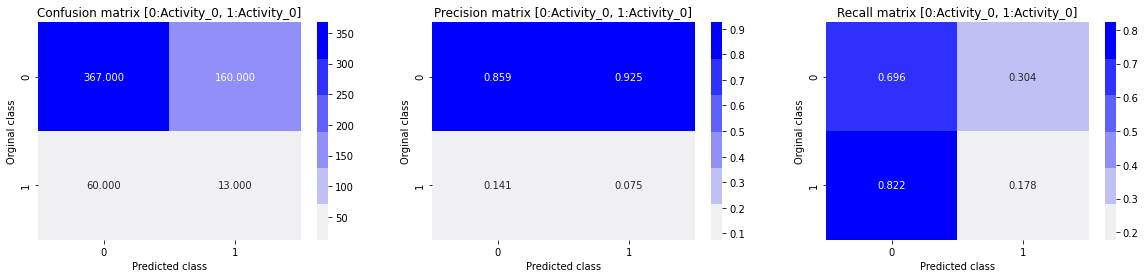

classification report on test(unseen) data

              precision    recall  f1-score   support

           0       0.86      0.70      0.77       527
           1       0.08      0.18      0.11        73

    accuracy                           0.63       600
   macro avg       0.47      0.44      0.44       600
weighted avg       0.76      0.63      0.69       600

Test accuracy on unseen data: 



0.6333333333333333

In [94]:
y_pred=model_Bi_1.predict_classes(X_test_ndarray,verbose=0)

# plotting Confusion matrix, Precision and Recall

plot_confusion_matrix(y_test,y_pred) # confusion matrix

print('classification report on test(unseen) data\n')  # Precision
print(classification_report(y_test,y_pred))

print('Test accuracy on unseen data: \n') # Recall
accuracy_score(y_test, y_pred)

In [87]:
early_stopping_cb= tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True) 
checkpointing_cb=tf.keras.callbacks.ModelCheckpoint('model_ckpt.h5') #checkpointing if there is any disruption while training
callbacks=[early_stopping_cb,checkpointing_cb]

In [83]:
# Model Desigining
model_lstm = Sequential()
# Configuring the parameters
model_lstm.add(LSTM(n_hidden, input_shape=(timesteps, input_dim),return_sequences=True))
# Adding a dropout layer
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(64,return_sequences=True))
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model_lstm.add(Dense(n_classes, activation='sigmoid'))
model_lstm.summary()


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 600, 32)           5504      
_________________________________________________________________
dropout_13 (Dropout)         (None, 600, 32)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 600, 64)           24832     
_________________________________________________________________
lstm_30 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 129,281
Trainable params: 129,281
Non-trainable params: 0
_______________________________________________

In [85]:
model_lstm.compile(
    optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=metrics
)

In [88]:
history_lstm=model_lstm.fit(x=X_train_ndarray,y=y_train,batch_size=batch_size,
          validation_data=(X_test_ndarray, y_test), epochs=epochs,class_weight=class_weight,callbacks=callbacks)

Epoch 1/30
88/88 [==============================] - 100s 1s/step - loss: 0.3671 - fn: 980.8182 - fp: 6467.8184 - tn: 52740.6836 - tp: 6522.5908 - precision: 0.5021 - recall: 0.8693 - val_loss: 0.4303 - val_fn: 991.4211 - val_fp: 6623.0791 - val_tn: 53470.9219 - val_tp: 6626.3687 - val_precision: 0.5001 - val_recall: 0.8699
Epoch 2/30
88/88 [==============================] - 100s 1s/step - loss: 0.3103 - fn: 1006.0682 - fp: 6728.7271 - tn: 54261.2383 - tp: 6715.8750 - precision: 0.4995 - recall: 0.8697 - val_loss: 0.2933 - val_fn: 1025.7894 - val_fp: 6790.4209 - val_tn: 55078.5781 - val_tp: 6817.0000 - val_precision: 0.5010 - val_recall: 0.8692
Epoch 3/30
88/88 [==============================] - 99s 1s/step - loss: 0.3940 - fn: 1040.4318 - fp: 6905.2500 - tn: 55850.7383 - tp: 6915.4888 - precision: 0.5004 - recall: 0.8692 - val_loss: 0.3595 - val_fn: 1052.1316 - val_fp: 7078.2368 - val_tn: 56565.7617 - val_tp: 7015.6577 - val_precision: 0.4978 - val_recall: 0.8696
Epoch 4/30
88/88 [====

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


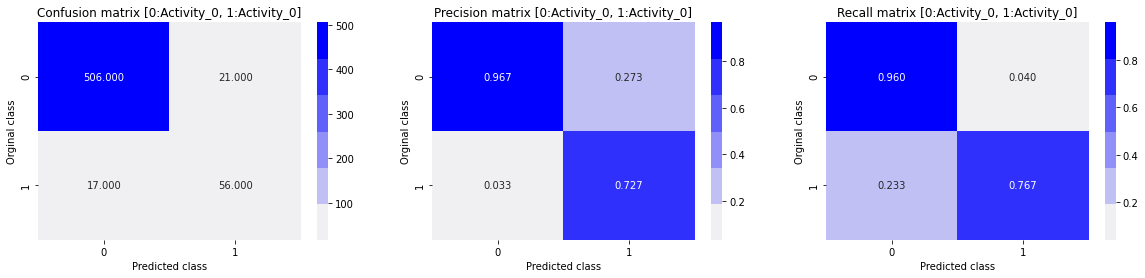

classification report on test(unseen) data

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       527
           1       0.73      0.77      0.75        73

    accuracy                           0.94       600
   macro avg       0.85      0.86      0.86       600
weighted avg       0.94      0.94      0.94       600

Test accuracy on unseen data: 



0.9366666666666666

In [93]:
y_pred=model_lstm.predict_classes(X_test_ndarray,verbose=0)

# plotting Confusion matrix, Precision and Recall

plot_confusion_matrix(y_test,y_pred) # confusion matrix

print('classification report on test(unseen) data\n')  # Precision
print(classification_report(y_test,y_pred))

print('Test accuracy on unseen data: \n') # Recall
accuracy_score(y_test, y_pred)

##Conclusion


*   The dataset set looking like activity recognition task, where readings are taken from 10 different variables  
*   The dataset consists of 2000 events and each event has different timesteps with 10 variables/features.


*   As Dataset has irregular timestep, it is necessary that we need to make them uniform for the model to train. There are two different stratergies to make the time stamp uniform.


1.   We can make every event to minimum timestamp, where we loose much information  or 
2.   we can pad each event to maximum the timestamp length. (I have selected this approach)



*   From exploratory data analysis, it is found that feature 7 is one of the main element in order to decide the class lable. where remaining features almost remains the same for both class labels
*   By performing PCA analysis, it is found that 99% of varianace of the complete dataset is explained by 4 features(In higher dimension) 


*   Either we can train with those 4 features in case if our dimensionality is more, which avoids curse of dimensionality.


*   As there are less data points it is very much possibile that our model can easily overfitted. Thereby we need to be careful while training deep networks. In the case of training deep network it is best to use dropouts (Avoids overfitting), residual networks(which helps in training better by giving higher epochs values)

*   Later model is trained using LSTM using different metric, because as dataset is completly imbalanced. Thereby accuracy can't be a best metric to be a metric. Thereby Precission, Recall, AU-ROC curve can be used.   
*   Later model is trained using the required metric and later test dataset is labels are predicted using the trained model and confusion metric has been ploted.

*   **model_Bi** can be used for prediction because of better performace on the test dataset









##Outlook

*   We can train our model with residual LSTM, by building deep networks and check the performance of the model using right metric. 

*   Due to resource and time constraint hyperparameter hasn't been carried




